# Variational AutoEncoder

In [1]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
torch.__version__

'1.9.0+cu102'

In [2]:
dataset_path = './data'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 100
input_dim  = 784
hidden_dim = 400
latent_dim = 200
lr = 1e-3
epochs = 100

## 1. Load Dataset

In [3]:
mnist_transform = transforms.ToTensor()
train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## 2. Define VAE Model 
* Encoder
* Decoder
* VAE

In [4]:
class Encoder(nn.Module):
    '''
     Encoder produces mean and log of variance 
    '''
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.input_layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2)
        )

        self.mean_fc = nn.Linear(hidden_dim, latent_dim) # maen
        self.var_fc = nn.Linear(hidden_dim, latent_dim) # var

    def forward(self, x):
        h = self.input_layers(x)

        mean = self.mean_fc(h)
        log_var = self.var_fc(h)
        return mean, log_var

In [5]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()

        self.hidden_layers = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim)
        )

        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h = self.hidden_layers(x)
        x_hat = self.output(h)

        return torch.sigmoid(x_hat)

In [6]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparameterization(self, mean, var):
        epsilon = torch.rand_like(var).to(device)
        z = mean + var * epsilon
        return z

    def forward(self, x):
        
        mean, log_var = self.encoder(x)
        var = torch.exp(0.5 * log_var)
        
        z = self.reparameterization(mean, var)
        x_hat = self.decoder(z)

        return x_hat, mean, log_var

In [7]:
encoder = Encoder(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim =input_dim)

model = VAE(encoder, decoder).to(device)

## 3. Loss Function & Optimizer

In [8]:
class ReproductionLoss(nn.Module):
    def __init__(self):
        super(ReproductionLoss, self).__init__()
    
    def reduction_bec_loss(self, x, x_hat, reduction='sum'):
        return nn.functional.binary_cross_entropy(x_hat, x, reduction=reduction)

    def culcuate_KLD(self, log_var):
        return - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    def forward(self, x, x_hat, mean, log_var):
        reduction_loss = self.reduction_bec_loss(x, x_hat)
        KDL = self.culcuate_KLD(log_var)

        return reduction_loss + KDL

In [9]:
from torch.optim import Adam
loss_function =  ReproductionLoss()
optimizer = Adam(model.parameters(), lr=lr)

## 4. Training VAE

In [10]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    this_epoch_loss = 0
    
    for batch_idx, (x, _) in enumerate(tqdm(train_loader)):
        x = x.view(batch_size, input_dim)
        x = x.to(device)
        optimizer.zero_grad()
        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        this_epoch_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", this_epoch_loss / (batch_idx*batch_size))

Start training VAE...


100%|██████████| 600/600 [00:12<00:00, 48.74it/s]


	Epoch 1 complete! 	Average Loss:  156.40325343671745


100%|██████████| 600/600 [00:12<00:00, 48.09it/s]


	Epoch 2 complete! 	Average Loss:  109.8095612479132


100%|██████████| 600/600 [00:12<00:00, 47.10it/s]


	Epoch 3 complete! 	Average Loss:  98.80273194582117


100%|██████████| 600/600 [00:12<00:00, 48.64it/s]


	Epoch 4 complete! 	Average Loss:  93.49988713285163


100%|██████████| 600/600 [00:12<00:00, 47.78it/s]


	Epoch 5 complete! 	Average Loss:  90.48982165914545


100%|██████████| 600/600 [00:12<00:00, 48.31it/s]


	Epoch 6 complete! 	Average Loss:  88.5111536480071


100%|██████████| 600/600 [00:12<00:00, 48.34it/s]


	Epoch 7 complete! 	Average Loss:  87.00951257466872


100%|██████████| 600/600 [00:12<00:00, 48.50it/s]


	Epoch 8 complete! 	Average Loss:  85.93312363053005


100%|██████████| 600/600 [00:12<00:00, 48.34it/s]


	Epoch 9 complete! 	Average Loss:  85.02502019968176


100%|██████████| 600/600 [00:12<00:00, 47.89it/s]


	Epoch 10 complete! 	Average Loss:  84.24116661721358


100%|██████████| 600/600 [00:12<00:00, 47.67it/s]


	Epoch 11 complete! 	Average Loss:  83.6233479382956


100%|██████████| 600/600 [00:12<00:00, 47.43it/s]


	Epoch 12 complete! 	Average Loss:  83.09943080590045


100%|██████████| 600/600 [00:12<00:00, 47.31it/s]


	Epoch 13 complete! 	Average Loss:  82.55688878436717


100%|██████████| 600/600 [00:12<00:00, 47.55it/s]


	Epoch 14 complete! 	Average Loss:  82.21267194184317


100%|██████████| 600/600 [00:12<00:00, 47.88it/s]


	Epoch 15 complete! 	Average Loss:  81.84817484707585


100%|██████████| 600/600 [00:12<00:00, 46.65it/s]


	Epoch 16 complete! 	Average Loss:  81.47807477795023


100%|██████████| 600/600 [00:12<00:00, 47.31it/s]


	Epoch 17 complete! 	Average Loss:  81.15578627954142


100%|██████████| 600/600 [00:12<00:00, 47.51it/s]


	Epoch 18 complete! 	Average Loss:  80.89602636066621


100%|██████████| 600/600 [00:12<00:00, 48.49it/s]


	Epoch 19 complete! 	Average Loss:  80.64919396096359


100%|██████████| 600/600 [00:12<00:00, 47.33it/s]


	Epoch 20 complete! 	Average Loss:  80.43338131912563


100%|██████████| 600/600 [00:12<00:00, 47.92it/s]


	Epoch 21 complete! 	Average Loss:  80.22704190415014


100%|██████████| 600/600 [00:12<00:00, 47.62it/s]


	Epoch 22 complete! 	Average Loss:  80.00301526306866


100%|██████████| 600/600 [00:12<00:00, 46.91it/s]


	Epoch 23 complete! 	Average Loss:  79.85567439058588


100%|██████████| 600/600 [00:12<00:00, 48.54it/s]


	Epoch 24 complete! 	Average Loss:  79.64059650198247


100%|██████████| 600/600 [00:12<00:00, 48.21it/s]


	Epoch 25 complete! 	Average Loss:  79.53991927463741


100%|██████████| 600/600 [00:12<00:00, 49.18it/s]


	Epoch 26 complete! 	Average Loss:  79.42994412888669


100%|██████████| 600/600 [00:12<00:00, 48.10it/s]


	Epoch 27 complete! 	Average Loss:  79.22525645770294


100%|██████████| 600/600 [00:12<00:00, 48.15it/s]


	Epoch 28 complete! 	Average Loss:  79.15530508203777


100%|██████████| 600/600 [00:12<00:00, 48.19it/s]


	Epoch 29 complete! 	Average Loss:  78.9855591513199


100%|██████████| 600/600 [00:12<00:00, 48.10it/s]


	Epoch 30 complete! 	Average Loss:  78.86400817769199


100%|██████████| 600/600 [00:12<00:00, 49.21it/s]


	Epoch 31 complete! 	Average Loss:  78.78979748963116


100%|██████████| 600/600 [00:12<00:00, 47.96it/s]


	Epoch 32 complete! 	Average Loss:  78.69040821616757


100%|██████████| 600/600 [00:12<00:00, 48.39it/s]


	Epoch 33 complete! 	Average Loss:  78.59232011849176


100%|██████████| 600/600 [00:12<00:00, 47.57it/s]


	Epoch 34 complete! 	Average Loss:  78.4809085617957


100%|██████████| 600/600 [00:12<00:00, 47.36it/s]


	Epoch 35 complete! 	Average Loss:  78.38675737231323


100%|██████████| 600/600 [00:12<00:00, 48.05it/s]


	Epoch 36 complete! 	Average Loss:  78.33123917466611


100%|██████████| 600/600 [00:12<00:00, 47.34it/s]


	Epoch 37 complete! 	Average Loss:  78.23509268376982


100%|██████████| 600/600 [00:12<00:00, 47.29it/s]


	Epoch 38 complete! 	Average Loss:  78.18135518833472


100%|██████████| 600/600 [00:12<00:00, 47.97it/s]


	Epoch 39 complete! 	Average Loss:  78.107754859988


100%|██████████| 600/600 [00:12<00:00, 47.60it/s]


	Epoch 40 complete! 	Average Loss:  78.0240034171536


100%|██████████| 600/600 [00:12<00:00, 46.76it/s]


	Epoch 41 complete! 	Average Loss:  77.93953961354862


100%|██████████| 600/600 [00:12<00:00, 46.90it/s]


	Epoch 42 complete! 	Average Loss:  77.92487725310413


100%|██████████| 600/600 [00:12<00:00, 47.99it/s]


	Epoch 43 complete! 	Average Loss:  77.8512155839159


100%|██████████| 600/600 [00:12<00:00, 48.74it/s]


	Epoch 44 complete! 	Average Loss:  77.78692188804257


100%|██████████| 600/600 [00:12<00:00, 48.31it/s]


	Epoch 45 complete! 	Average Loss:  77.7628410958368


100%|██████████| 600/600 [00:12<00:00, 49.73it/s]


	Epoch 46 complete! 	Average Loss:  77.6374044957742


100%|██████████| 600/600 [00:12<00:00, 48.70it/s]


	Epoch 47 complete! 	Average Loss:  77.60201261542676


100%|██████████| 600/600 [00:12<00:00, 49.00it/s]


	Epoch 48 complete! 	Average Loss:  77.51973290445012


100%|██████████| 600/600 [00:12<00:00, 47.90it/s]


	Epoch 49 complete! 	Average Loss:  77.46601203014139


100%|██████████| 600/600 [00:12<00:00, 48.06it/s]


	Epoch 50 complete! 	Average Loss:  77.44708977038553


100%|██████████| 600/600 [00:12<00:00, 48.29it/s]


	Epoch 51 complete! 	Average Loss:  77.3990422514086


100%|██████████| 600/600 [00:12<00:00, 47.98it/s]


	Epoch 52 complete! 	Average Loss:  77.35285898861383


100%|██████████| 600/600 [00:12<00:00, 49.41it/s]


	Epoch 53 complete! 	Average Loss:  77.33521732999009


100%|██████████| 600/600 [00:12<00:00, 48.05it/s]


	Epoch 54 complete! 	Average Loss:  77.27041442769199


100%|██████████| 600/600 [00:12<00:00, 47.97it/s]


	Epoch 55 complete! 	Average Loss:  77.2290199812187


100%|██████████| 600/600 [00:12<00:00, 47.97it/s]


	Epoch 56 complete! 	Average Loss:  77.18561866620148


100%|██████████| 600/600 [00:12<00:00, 47.12it/s]


	Epoch 57 complete! 	Average Loss:  77.11272046835872


100%|██████████| 600/600 [00:12<00:00, 47.39it/s]


	Epoch 58 complete! 	Average Loss:  77.12669765364149


100%|██████████| 600/600 [00:12<00:00, 48.13it/s]


	Epoch 59 complete! 	Average Loss:  77.097303505517


100%|██████████| 600/600 [00:12<00:00, 47.77it/s]


	Epoch 60 complete! 	Average Loss:  77.05339590235027


100%|██████████| 600/600 [00:12<00:00, 47.98it/s]


	Epoch 61 complete! 	Average Loss:  76.98085670942456


100%|██████████| 600/600 [00:12<00:00, 48.34it/s]


	Epoch 62 complete! 	Average Loss:  76.98015165249375


100%|██████████| 600/600 [00:12<00:00, 48.86it/s]


	Epoch 63 complete! 	Average Loss:  76.93874020992018


100%|██████████| 600/600 [00:12<00:00, 48.90it/s]


	Epoch 64 complete! 	Average Loss:  76.88620841050188


100%|██████████| 600/600 [00:12<00:00, 49.69it/s]


	Epoch 65 complete! 	Average Loss:  76.90351273933118


100%|██████████| 600/600 [00:12<00:00, 48.99it/s]


	Epoch 66 complete! 	Average Loss:  76.81207896135486


100%|██████████| 600/600 [00:12<00:00, 49.73it/s]


	Epoch 67 complete! 	Average Loss:  76.79767869952525


100%|██████████| 600/600 [00:12<00:00, 49.03it/s]


	Epoch 68 complete! 	Average Loss:  76.83433276652494


100%|██████████| 600/600 [00:12<00:00, 49.41it/s]


	Epoch 69 complete! 	Average Loss:  76.76604773417937


100%|██████████| 600/600 [00:12<00:00, 48.55it/s]


	Epoch 70 complete! 	Average Loss:  76.70389293842602


100%|██████████| 600/600 [00:12<00:00, 48.35it/s]


	Epoch 71 complete! 	Average Loss:  76.66035338030832


100%|██████████| 600/600 [00:12<00:00, 49.02it/s]


	Epoch 72 complete! 	Average Loss:  76.68916613137782


100%|██████████| 600/600 [00:12<00:00, 48.22it/s]


	Epoch 73 complete! 	Average Loss:  76.63535706483462


100%|██████████| 600/600 [00:12<00:00, 49.00it/s]


	Epoch 74 complete! 	Average Loss:  76.62167513075177


100%|██████████| 600/600 [00:12<00:00, 48.82it/s]


	Epoch 75 complete! 	Average Loss:  76.60943589250313


100%|██████████| 600/600 [00:12<00:00, 47.89it/s]


	Epoch 76 complete! 	Average Loss:  76.5722905200073


100%|██████████| 600/600 [00:12<00:00, 48.91it/s]


	Epoch 77 complete! 	Average Loss:  76.5588034745409


100%|██████████| 600/600 [00:12<00:00, 49.01it/s]


	Epoch 78 complete! 	Average Loss:  76.53623994091716


100%|██████████| 600/600 [00:12<00:00, 48.28it/s]


	Epoch 79 complete! 	Average Loss:  76.52039496980645


100%|██████████| 600/600 [00:12<00:00, 48.25it/s]


	Epoch 80 complete! 	Average Loss:  76.46368968626095


100%|██████████| 600/600 [00:12<00:00, 47.69it/s]


	Epoch 81 complete! 	Average Loss:  76.43694027806761


100%|██████████| 600/600 [00:12<00:00, 47.42it/s]


	Epoch 82 complete! 	Average Loss:  76.46819212033076


100%|██████████| 600/600 [00:12<00:00, 48.50it/s]


	Epoch 83 complete! 	Average Loss:  76.38132259821056


100%|██████████| 600/600 [00:12<00:00, 49.00it/s]


	Epoch 84 complete! 	Average Loss:  76.40390368224385


100%|██████████| 600/600 [00:12<00:00, 48.75it/s]


	Epoch 85 complete! 	Average Loss:  76.34897045205551


100%|██████████| 600/600 [00:12<00:00, 47.87it/s]


	Epoch 86 complete! 	Average Loss:  76.35906760290588


100%|██████████| 600/600 [00:12<00:00, 48.58it/s]


	Epoch 87 complete! 	Average Loss:  76.31262657815108


100%|██████████| 600/600 [00:12<00:00, 48.78it/s]


	Epoch 88 complete! 	Average Loss:  76.28621066034536


100%|██████████| 600/600 [00:12<00:00, 48.70it/s]


	Epoch 89 complete! 	Average Loss:  76.2971938011921


100%|██████████| 600/600 [00:12<00:00, 47.88it/s]


	Epoch 90 complete! 	Average Loss:  76.26160452968489


100%|██████████| 600/600 [00:12<00:00, 47.80it/s]


	Epoch 91 complete! 	Average Loss:  76.25994205022694


100%|██████████| 600/600 [00:12<00:00, 47.95it/s]


	Epoch 92 complete! 	Average Loss:  76.2207574310048


100%|██████████| 600/600 [00:12<00:00, 47.47it/s]


	Epoch 93 complete! 	Average Loss:  76.21028717295754


100%|██████████| 600/600 [00:12<00:00, 48.05it/s]


	Epoch 94 complete! 	Average Loss:  76.18481596117226


100%|██████████| 600/600 [00:12<00:00, 48.42it/s]


	Epoch 95 complete! 	Average Loss:  76.17698451683796


100%|██████████| 600/600 [00:12<00:00, 48.47it/s]


	Epoch 96 complete! 	Average Loss:  76.15078847232367


100%|██████████| 600/600 [00:12<00:00, 47.96it/s]


	Epoch 97 complete! 	Average Loss:  76.1134944226706


100%|██████████| 600/600 [00:12<00:00, 47.86it/s]


	Epoch 98 complete! 	Average Loss:  76.10814098530102


100%|██████████| 600/600 [00:12<00:00, 48.47it/s]


	Epoch 99 complete! 	Average Loss:  76.10660463565578


100%|██████████| 600/600 [00:12<00:00, 47.99it/s]

	Epoch 100 complete! 	Average Loss:  76.05002089256834


## 5. Generate images from test dataset

In [11]:
import matplotlib.pyplot as plt

def show_image(x, idx):
    x = x.view(batch_size, 28, 28)
    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

In [12]:
model.eval()
with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, input_dim)
        x = x.to(device)
        x_hat, _, _ = model(x)

        break

  0%|          | 0/100 [00:00<?, ?it/s]


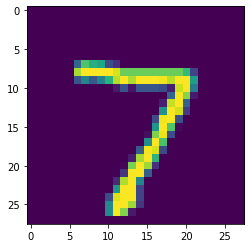

In [13]:
show_image(x, idx=0)

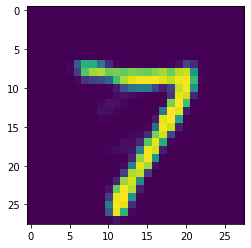

In [14]:
show_image(x_hat, idx=0)

In [26]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(device)
    generated_images = decoder(noise)

In [27]:
save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')

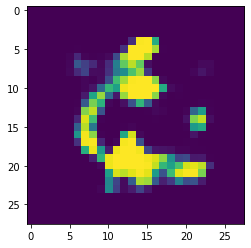

In [28]:
show_image(generated_images, idx=0)

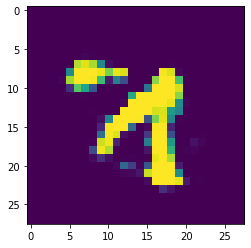

In [29]:
show_image(generated_images, idx=10)